In [2]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
logs = []

for file in os.listdir("./logs"):
    if file.endswith(".json"):
        log = open(os.path.join("./logs", file)).read()
        logs = logs + json.loads(log)

In [4]:
def splitLog (d):
    j = json.loads(d['text'].split('```')[3])
    if ('value' in j['body']):
        body = j['body']['value']
    else:
        body = None
    return {
        "err": d["err"],
        "real-ip": j["headers"]["x-real-ip"],
        "fowarded-for": j["headers"]["x-forwarded-for"],
        "url": j["url"],
        "user-agent": j["headers"]["user-agent"],
        "ts": d['ts'],
        "voto": body
    }

f = filter(lambda x: 'attachments' in x, logs)
m = map(lambda x: { "text": x['attachments'][0]['text'], "ts": x['attachments'][0]['ts'], "err": x['attachments'][0]['fallback']}, f)
l = map(lambda x: splitLog(x), m)
f2 = filter(lambda x: x['voto'], l)
l2 = map(lambda x: splitLog(x), m)

In [5]:
# logs[0]

In [6]:
df = pd.DataFrame(l2)
df = df[df['url'].str.contains("poll")]

In [7]:
df.to_csv('rosario-alerts.csv', index=False, encoding='utf-8')

In [8]:
# df['ts'] = df['ts'].astype(float)
df['ts'] = pd.to_datetime(df['ts'], unit='s')
df.index = pd.DatetimeIndex(df['ts'])

In [34]:
ips = df.groupby('real-ip').count()
ipsS = ips.sort_values('err', ascending=False)[:1000].index

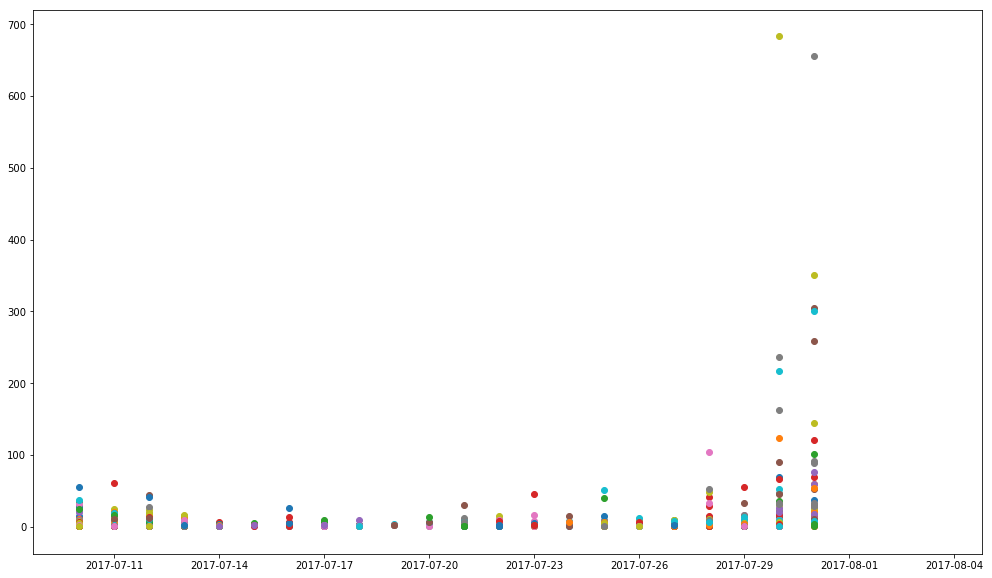

In [35]:
plt.figure(figsize=(17, 10))
for y in df[df['real-ip'].isin(ipsS)].groupby('real-ip'):
    ipt = y[1].groupby(y[1].index.date).count()
#     print y[0]
    plt.scatter(ipt.index, ipt['real-ip'])
#     plt.show()

In [11]:
for i in range(5):
    print df[df['real-ip'] == ipsS[i]]['voto'].unique()
    print df[df['real-ip'] == ipsS[i]]['url'].unique()
    print '-------------------'

[u'Opci\xf3n B - Garrote G - Persig T'
 u'Opci\xf3n A - Garrote G - Persig T']
[u'/topics/5963a00bb9431300019115fe/poll'
 u'/topics/5963a36ab9431300019119cd/poll']
-------------------
[u'Opci\xf3n B - Garrote G - Persig T' u'opci\xf3n B - Colmenares Jos\xe9'
 u'Opci\xf3n A - Garrote G - Persig T']
[u'/topics/5963a00bb9431300019115fe/poll'
 u'/topics/5963a4e1b943130001911a7b/poll'
 u'/topics/5963a36ab9431300019119cd/poll']
-------------------
[u'Opci\xf3n B - Rossi L - Turri B' u'Opci\xf3n A - Camuratti Ariel'
 u'Opci\xf3n B - Manzi M' u'Opci\xf3n A - Gassman Vitali'
 u'Opci\xf3n A - Grupo Essex']
[u'/topics/5963a36ab9431300019119cd/poll'
 u'/topics/5963a00bb9431300019115fe/poll'
 u'/topics/5963ab0db94313000191214e/poll'
 u'/topics/5963a7c6b943130001911db4/poll'
 u'/topics/59639dccb94313000191151a/poll']
-------------------
[u'Opci\xf3n B - Garrote G - Persig T'
 u'Opci\xf3n A - Garrote G - Persig T' u'opci\xf3n B - Colmenares Jos\xe9'
 u'Opci\xf3n A - Grupo Essex' u'Opci\xf3n A - Artis

In [12]:
topic1 = json.loads(open(os.path.join(".", "topic3.json")).read())
topic2 = json.loads(open(os.path.join(".", "topic4.json")).read())

In [13]:
dff1 = pd.DataFrame(topic1['participants'])
dff2 = pd.DataFrame(topic2['participants'])

In [14]:
print len(dff1)
print len(dff1.groupby('$oid').count())

print len(dff2)
print len(dff2.groupby('$oid').count())

1662
1662
1179
1179


In [15]:
dg = pd.read_csv('tmp.users.csv')

In [16]:
dg = dg[[u'_id', u'attempts', u'createdAt', u'email', u'firstName',\
       u'last', u'lastName']]
dg['votoenconsulta1'] = dg['_id'].isin(dff1['$oid'])
dg['votoenconsulta1'] = dg['votoenconsulta1'].apply(lambda x: 1 if x else 0 )

dg['votoenconsulta2'] = dg['_id'].isin(dff2['$oid'])
dg['votoenconsulta2'] = dg['votoenconsulta2'].apply(lambda x: 1 if x else 0 )

In [17]:
dg['createdAt'] = pd.to_datetime(dg['createdAt'])
dg.index = pd.DatetimeIndex(dg['createdAt'])

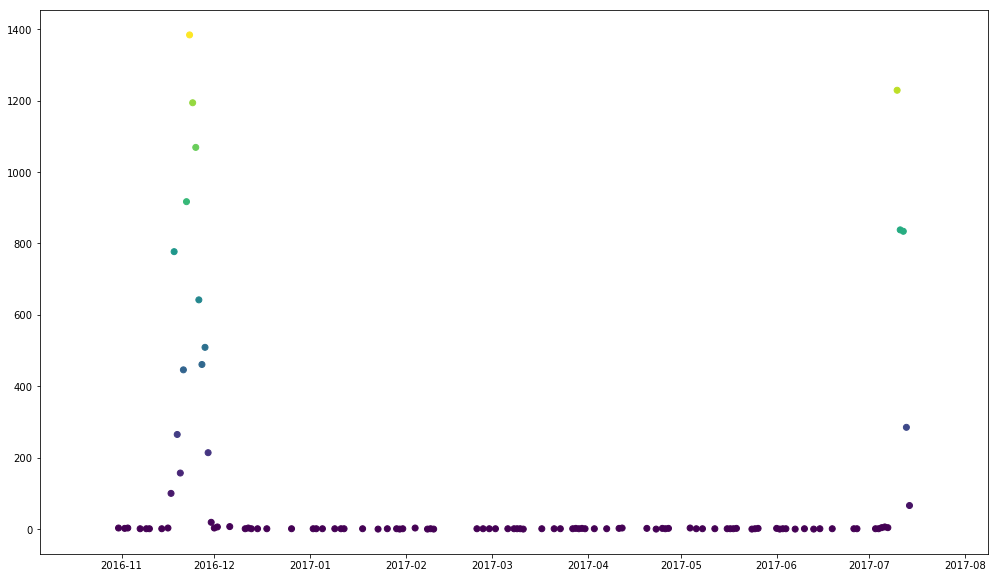

In [18]:
plt.figure(figsize=(17, 10))
ipt = dg.groupby(dg.index.date).count()
plt.scatter(ipt.index, ipt['email'], c=ipt['votoenconsulta2'])

In [19]:
dc = pd.read_csv('votos-consultas.csv')

In [20]:
consultasS = ['5963a00bb9431300019115fe',
 '5963a36ab9431300019119cd',
 '5963a4e1b943130001911a7b',
 '59639dccb94313000191151a']

dc['votoenconsulta1'] = dc['consulta'].isin(consultasS)
dc['votoenconsulta1'] = dc['votoenconsulta1'].apply(lambda x: 1 if x else 0 )

In [21]:
dc['fechaVotacion'] = pd.to_datetime(dc['fechaVotacion']).astype(int)
dc['usuarioCreacion.0'] = pd.to_datetime(dc['usuarioCreacion.0']).astype(int)

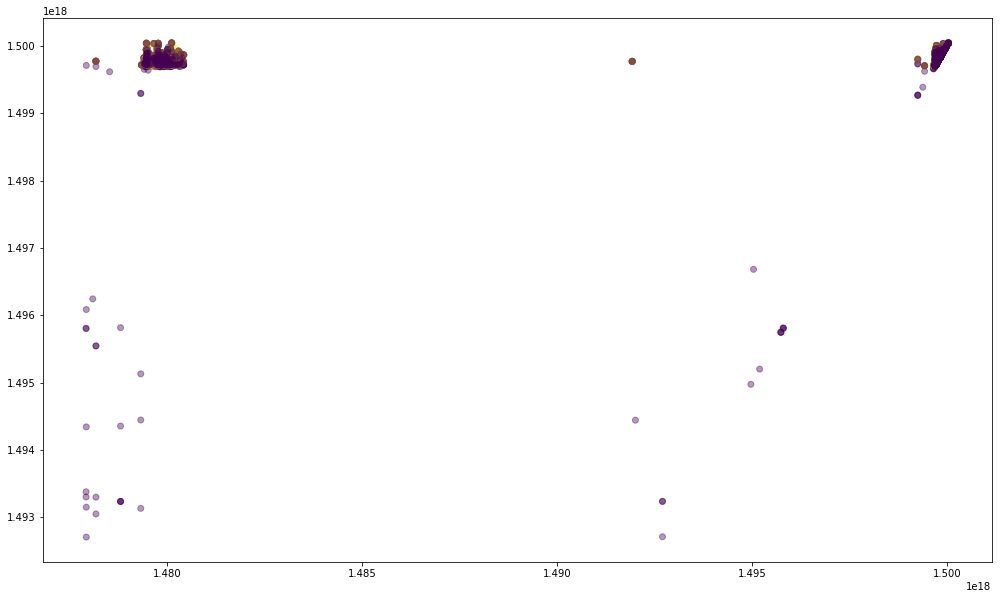

In [22]:
plt.figure(figsize=(17, 10))
plt.scatter(dc['usuarioCreacion.0'], dc['fechaVotacion'], c=dc['votoenconsulta1'], alpha=.4)

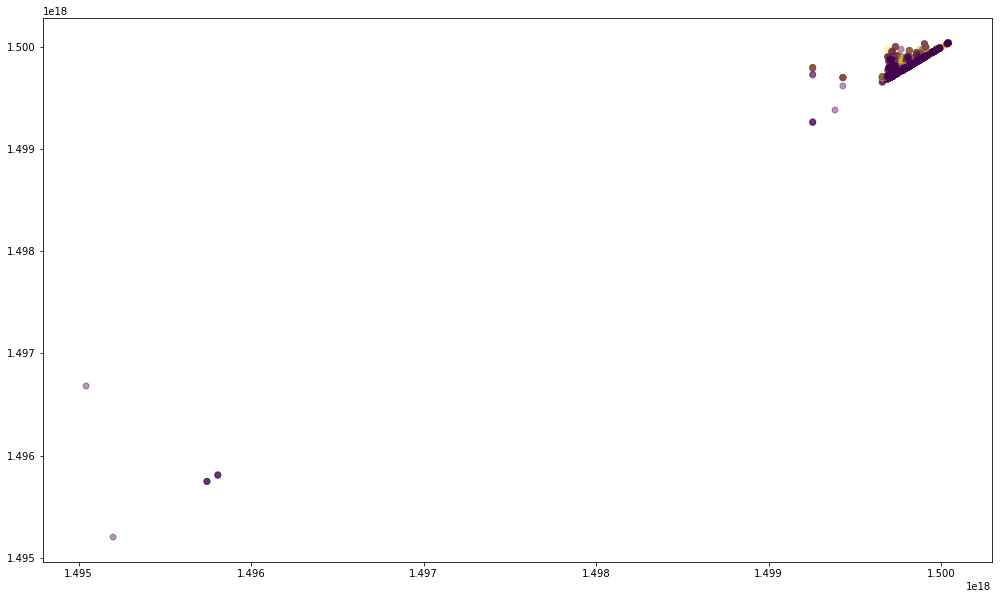

In [23]:
dc2 = dc[(dc['usuarioCreacion.0'] > 1495000000000000000) & (dc['fechaVotacion'] > 1495000000000000000)]
# dc2
plt.figure(figsize=(17, 10))
plt.scatter(dc2['usuarioCreacion.0'], dc2['fechaVotacion'], c=dc2['votoenconsulta1'], alpha=.4)

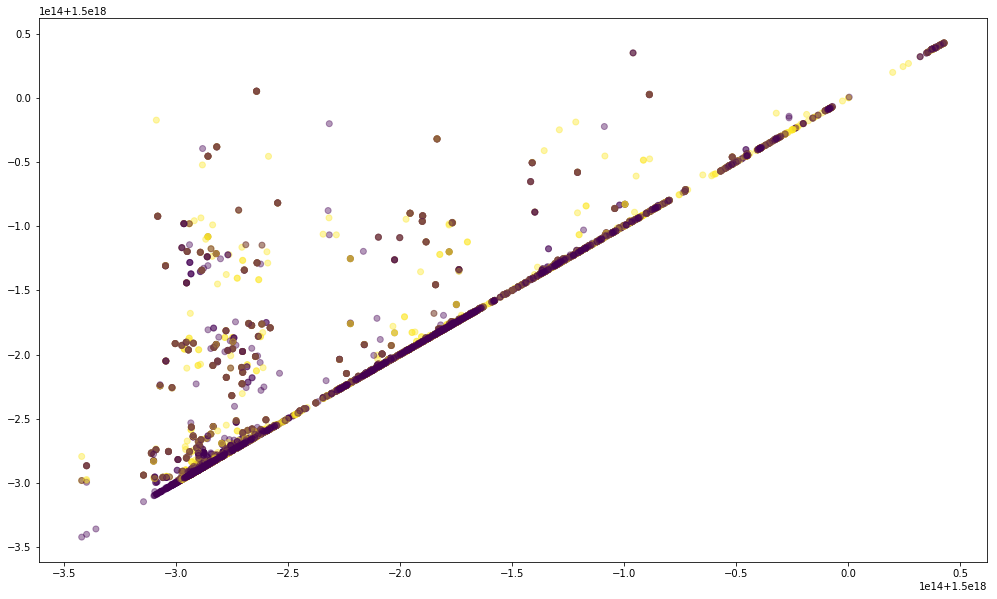

In [24]:
dc2 = dc[(dc['usuarioCreacion.0'] > 1499500000000000000) & (dc['fechaVotacion'] > 1499500000000000000)]
# dc2
plt.figure(figsize=(17, 10))
plt.scatter(dc2['usuarioCreacion.0'], dc2['fechaVotacion'], c=dc2['votoenconsulta1'], alpha=.4)

/home/frn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


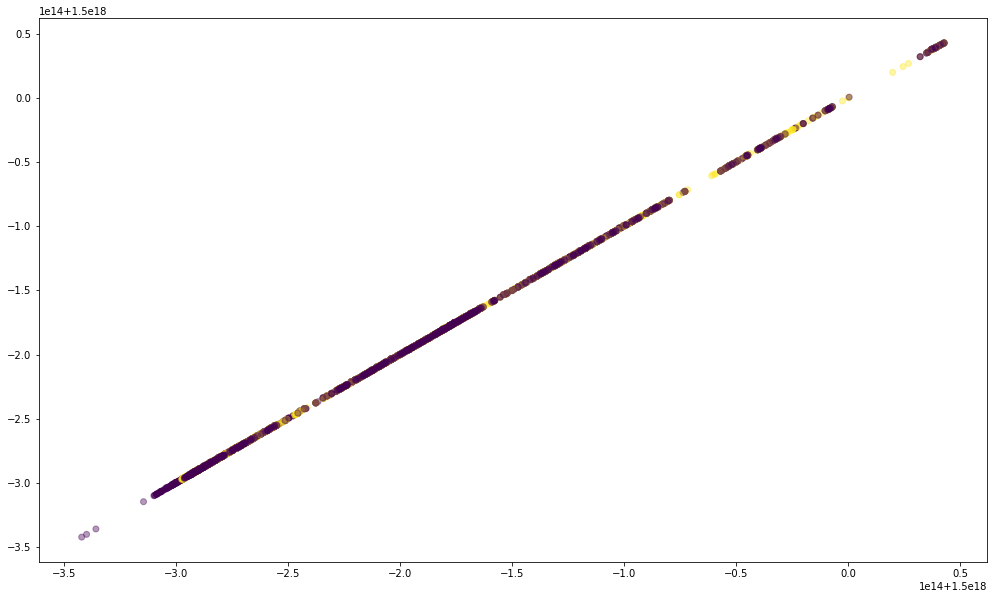

In [25]:
dc2['diff'] = dc2['fechaVotacion'] - dc2['usuarioCreacion.0']
dc3 = dc2[dc2['diff'] < 1000000000000]

plt.figure(figsize=(17, 10))
plt.scatter(dc3['usuarioCreacion.0'], dc3['fechaVotacion'], c=dc3['votoenconsulta1'], alpha=.4)

In [26]:
dc3['mailHosts'] = dc3['usuarioEmail.0'].astype(str).apply(lambda x: x.split('@')).apply(lambda x: None if len(x) == 1 else x[1])
dc3.groupby('mailHosts').count().sort_values('consulta', ascending=False).head(30)

/home/frn/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,_id,arrayIndex,consulta,fechaVotacion,usuario,usuarioCreacion.0,usuarioEmail.0,voto,votoenconsulta1,diff
mailHosts,,,,,,,,,,
hotmail.com,4513,4513,4513,4513,4513,4513,4513,4513,4513,4513
gmail.com,2560,2560,2560,2560,2560,2560,2560,2560,2560,2560
pokemail.net,467,467,467,467,467,467,467,467,467,467
grr.la,304,304,304,304,304,304,304,304,304,304
yahoo.com.ar,275,275,275,275,275,275,275,275,275,275
live.com.ar,105,105,105,105,105,105,105,105,105,105
hotmail.com.ar,104,104,104,104,104,104,104,104,104,104
outlook.com,97,97,97,97,97,97,97,97,97,97
yopmail.com,92,92,92,92,92,92,92,92,92,92


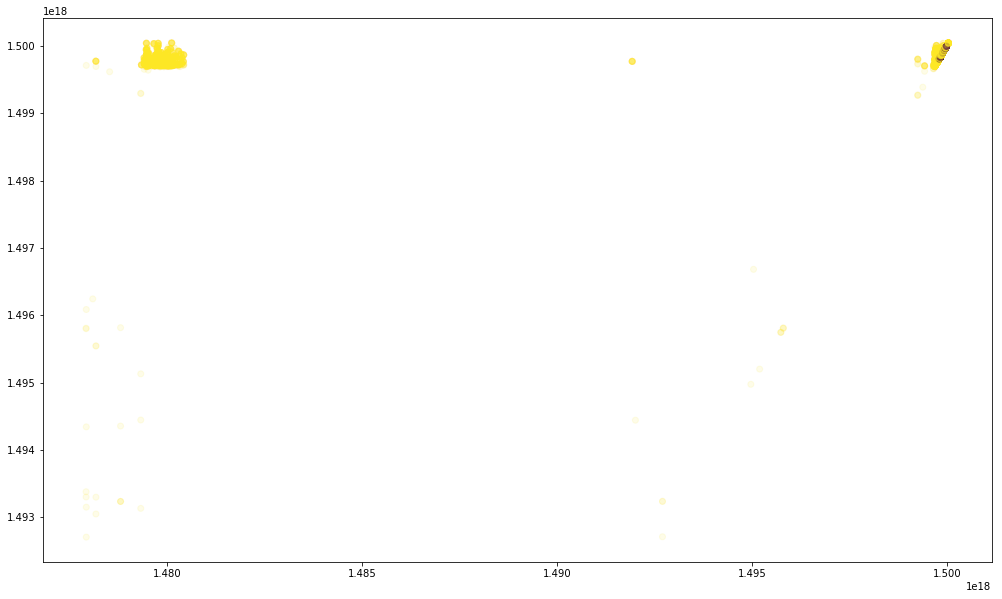

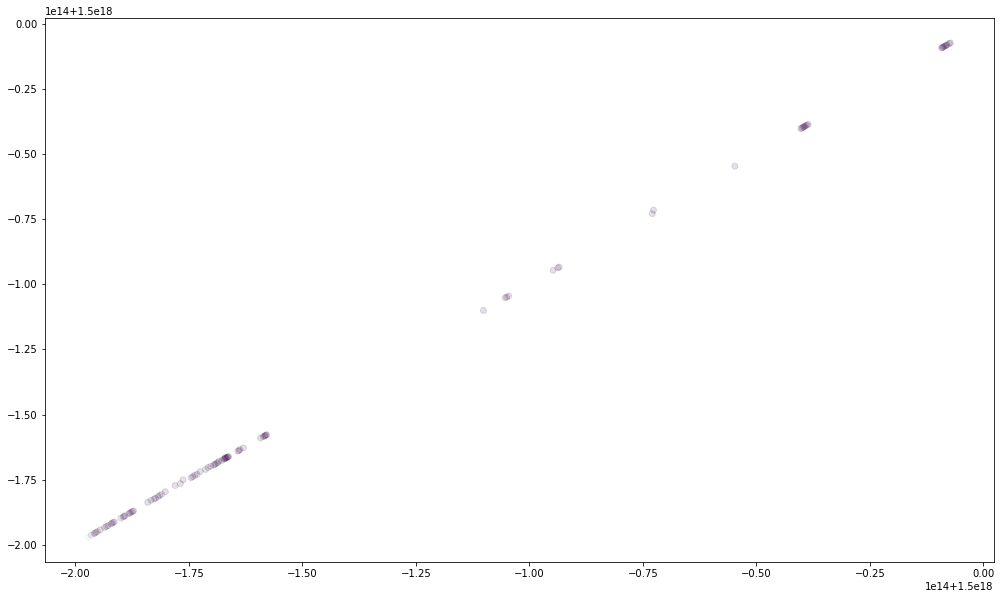

In [27]:
dc['mailHosts'] = dc['usuarioEmail.0'].astype(str).apply(lambda x: x.split('@')).apply(lambda x: None if len(x) == 1 else x[1])
dc.groupby('mailHosts').count().sort_values('consulta', ascending=False)
trucho = ['pokemail.net', 'grr.la', 'yopmail.com', 'sharklasers.com']

dc['estrucho'] = dc['mailHosts'].isin(trucho)
dc['estrucho'] = dc['estrucho'].apply(lambda x: 0 if x else 1 )

plt.figure(figsize=(17, 10))
plt.scatter(dc['usuarioCreacion.0'], dc['fechaVotacion'], c=dc['estrucho'], alpha=.1)

dc4 = dc[dc['estrucho'] == 0]

plt.figure(figsize=(17, 10))
plt.scatter(dc4['usuarioCreacion.0'], dc4['fechaVotacion'], c=dc4['estrucho'], alpha=.01)

In [28]:
len(dc4)

900

In [29]:
len(dc4['usuario'].unique())

93

In [30]:
len(dc4['consulta'].unique())

10

In [31]:
dc4['voto'].count()

900

In [38]:
len(dc4['voto'].unique())


18

In [43]:
dc4.groupby(['consulta', 'voto']).count()['_id']

consulta                  voto                               
595cffcda16b0c0004943e53  Opción A - Artista Esteban Crispino    15
                          Opción B - Artista Nicolás López       74
59639ac7b94313000191139f  Opción A - Di Tommaso Ana Laura        28
                          Opción B - Villafañe Mariana           59
59639dccb94313000191151a  Opción A - Grupo Essex                 28
                          Opción B - Lopez Nicolás               61
5963a00bb9431300019115fe  Opción A - Camuratti Ariel             92
                          Opción B - Garrote G - Persig T         1
5963a36ab9431300019119cd  Opción A - Garrote G - Persig T        20
                          Opción B - Rossi L - Turri B           69
5963a4e1b943130001911a7b  Opción A - Camuratti Ariel             92
                          opción B - Colmenares José              1
5963a5f8b943130001911af1  Opción A - Crispino Bruno              40
                          Opción B - Manzi M - Perriar

In [44]:
dc4

,_id,arrayIndex,consulta,fechaVotacion,usuario,usuarioCreacion.0,usuarioEmail.0,voto,votoenconsulta1,mailHosts,estrucho
972,5963a36ab9431300019119cd,935,5963a36ab9431300019119cd,1499804409962000000,596532a5b94313000192229e,1499804325206000000,palomasd@grr.la,Opción B - Rossi L - Turri B,1,grr.la,0
975,5963a36ab9431300019119cd,938,5963a36ab9431300019119cd,1499804727829000000,5965339e0cafe50001689660,1499804574731000000,kiritokun@pokemail.net,Opción B - Rossi L - Turri B,1,pokemail.net,0
982,5963a36ab9431300019119cd,945,5963a36ab9431300019119cd,1499805639939000000,596537139431240001af8f56,1499805459870000000,kukusklan@yopmail.com,Opción B - Rossi L - Turri B,1,yopmail.com,0
988,5963a36ab9431300019119cd,951,5963a36ab9431300019119cd,1499806625100000000,59653aed9431240001af8fb4,1499806445382000000,lopezuru@yopmail.com,Opción B - Rossi L - Turri B,1,yopmail.com,0
990,5963a36ab9431300019119cd,953,5963a36ab9431300019119cd,1499806977532000000,59653c7e9431240001af8fd8,1499806846204000000,marumendoza@yopmail.com,Opción B - Rossi L - Turri B,1,yopmail.com,0
994,5963a36ab9431300019119cd,957,5963a36ab9431300019119cd,1499807301345000000,59653df49431240001af8ff4,1499807220657000000,ocbariel@yopmail.com,Opción B - Rossi L - Turri B,1,yopmail.com,0
999,5963a36ab9431300019119cd,962,5963a36ab9431300019119cd,1499807989538000000,596540a5b9431300019223ec,1499807909524000000,julianroperto@grr.la,Opción B - Rossi L - Turri B,1,grr.la,0
1001,5963a36ab9431300019119cd,964,5963a36ab9431300019119cd,1499808235139000000,5965416c9431240001af9274,1499808108279000000,julialopez@grr.la,Opción B - Rossi L - Turri B,1,grr.la,0
1004,5963a36ab9431300019119cd,967,5963a36ab9431300019119cd,1499808512225000000,596542500cafe5000168980b,1499808336687000000,incubusser@grr.la,Opción B - Rossi L - Turri B,1,grr.la,0
1007,5963a36ab9431300019119cd,970,5963a36ab9431300019119cd,1499808708380000000,59654355b943130001922443,1499808597517000000,casajusdario@grr.la,Opción B - Rossi L - Turri B,1,grr.la,0
